# 05-Error Metrics

_[Estimated execution time: 15 min]_

The toolkit allows to evaluate standar error metrics automaticaly, as well as only obtaint the raw error values and compute error metrics not included in the toolkit.

This notebook will continue on the Air quality dataset, used in the previous tutorial [04-Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb)

## Usage notes
This toolkit works in the following order:- Set up the input data
- Create model (SM, MOSM, CSM, SM-LMC, CG)
- Make an estimation of the model parameters using BNSE+SM
- Train the model parameters
- Set the prediction range
- Do a prediction For example:

#### Imports and plot format

In [1]:
import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Air Quality MOGP


The dataset hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device.

The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.

We will only use 5 columns CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT).

The same as the previous tutorial [04-Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb) We load, the dataset, replace the sensor failures (-200) with nans and convert the date columns to hours.

In [2]:
# load
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# replace missing values with nan
df.replace(-200.0, np.nan, inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['Time'] = (df['Date'] - ini_date) / pd.Timedelta(hours=1)

# use only the first 8 days of data
df2 = df[df['Date'] < pd.Timestamp('2004-03-19 00:00:00.0')]

dataset = mogptk.LoadDataFrame(df2,
                    x_col='Time',
                    y_col=cols)

In this case for each channel we will first remove 50% of the observations and then remove complete sectors in order to get a reconstructions from the other channels.

we will also use the transformation defined in the data prepararion and transformation tutorial [02-Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb) where each channel is normalized so it has mean 0 and variance 1.

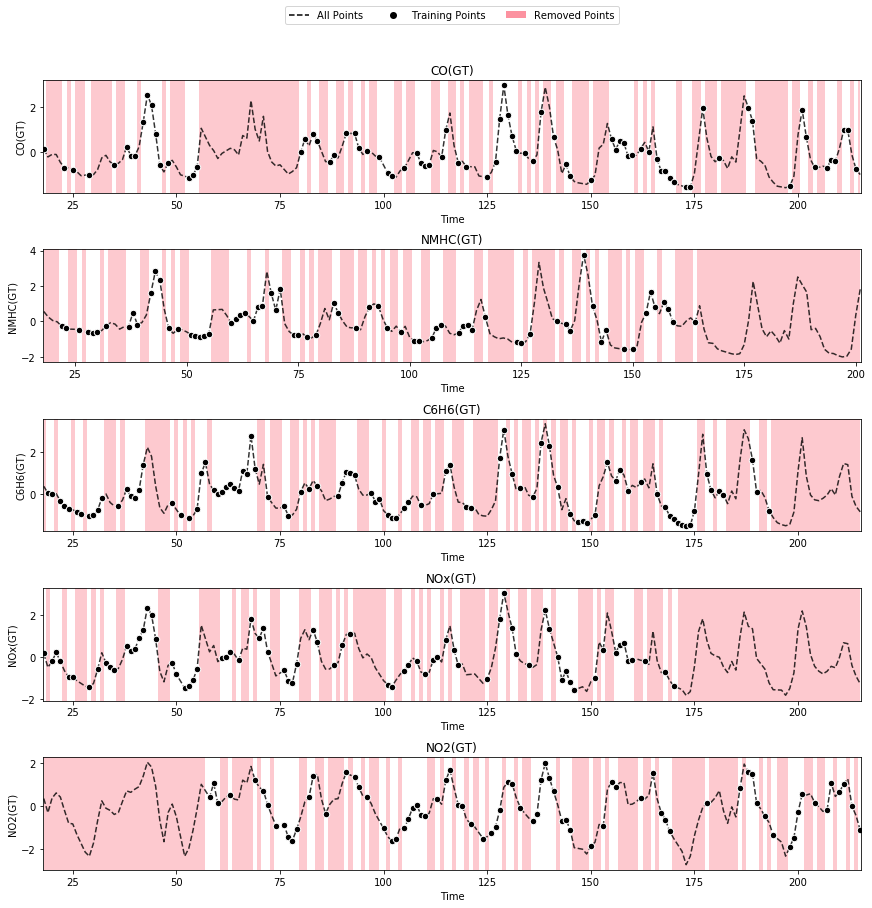

In [3]:
for channel in dataset:
    channel.remove_randomly(pct=0.5)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, None)
dataset[2].remove_relative_range(0.9, None)
dataset[3].remove_relative_range(0.8, None)
dataset[4].remove_relative_range(None, 0.2)


for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    channel.transform(mogptk.TransformWhiten())
dataset.plot();

Then we create the test inputs and output using the atribute `mogptk.Data.mask` which contain booleans indicating if the point mas removed or not, removed points will be treated as test points.

In [4]:
x_test, y_test = dataset.get_test_data()

# Models

We will use one of each of the models in the toolkit, starting with independent Gaussian processes with [SM](https://games-uchile.github.io/mogptk/sm.html) kernel.

### 1-Independent GP with spectral mixture kernel

For each channel we will use Q=4

In [5]:
Q = 4 # number of mixtures
n_channels = len(dataset)

# list of the models
igp_list = []

for i in range(n_channels):
    model = mogptk.SM(dataset[i], Q=Q)
    model.init_parameters('BNSE')
    
    model.train(method='L-BFGS-B', maxiter=1000, tol=1e-30, verbose=True)
    igp_list.append(model)

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 4
 >Training points: 82
 >Parameters: 13
 >Initial NLL: 116.169
Optimization finished in 0.08 minutes
 >Final NLL: 85.669 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 4
 >Training points: 70
 >Parameters: 13
 >Initial NLL: 97.085
Optimization finished in 0.05 minutes
 >Final NLL: 72.473 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 4
 >Training points: 93
 >Parameters: 13
 >Initial NLL: 123.985
Optimization finished in 0.04 minutes
 >Final NLL: 90.424 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 4
 >Training points: 76
 >Parameters: 13
 >Initial NLL: 102.096
Optimization finished in 0.03 minutes
 >Final NLL: 87.112 

Starting optimization
 >Model: SM
 >Channels: 1                    
 >Components: 4
 >Training points: 77
 >Parameters: 13
 >Initial NLL: 103.511
Optimization finished in 0.02 m

## Evaluating errors

using the function [`mogptk.test_errors`](https://games-uchile.github.io/mogptk/errors.html#mogptk.errors.test_errors) given a test input and output it calculates:

* Mean Absolute Error (MAE)
* range-Normalized Mean Absolute Error (nMAE)
* Root Mean Squared Error (RMSE)
* range-Normalized Mean Absolute Squared Error (nRMSE)

If only the raw values $(y_{pred} - y_{true})$ are wanted, the flag `raw_errors` must be set to `True`.

Multiple models for the same test set (x_test, y_test) can be passed at once, the result will be a list with one element for each model passed, where each element is another list of length equal to the number or channels where each element is the error for said model, said channel.

This enables to obtain errors for multiple models for the same test set, where each channel can have different number of test points.

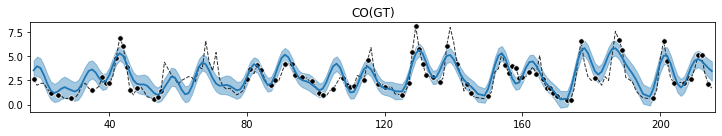

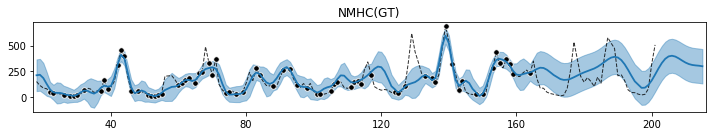

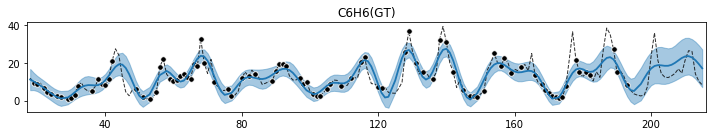

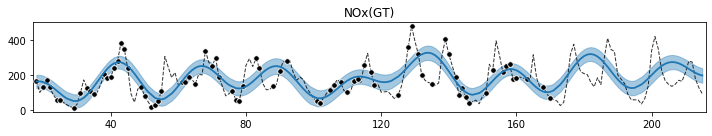

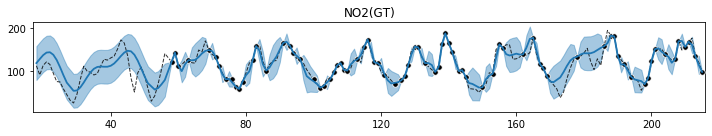

In [6]:
for model in igp_list:
    model.predict(dataset[0].X)
    model.plot_prediction(figsize=(10, 2))

In [7]:
igp_errors = np.zeros((n_channels, 4))

for i in range(n_channels):
    igp_errors[i, :] = mogptk.test_errors(igp_list[i], x_test=x_test[i], y_test=y_test[i])[0][0]
    
pd.DataFrame(igp_errors,
             columns=['MAE', 'nMAE', 'RMSE', 'nRMSE'],
             index=cols)

,MAE,nMAE,RMSE,nRMSE
CO(GT),0.948591,0.128188,1.188419,0.160597
NMHC(GT),92.534069,0.152445,123.985617,0.204260
C6H6(GT),4.499026,0.118085,5.999178,0.157459
NOx(GT),78.249139,0.195623,94.148578,0.235371
NO2(GT),16.445717,0.099071,21.963200,0.132308


## 2-Multioutput Spectral Mixture (MOSM)

Next we use the multioutput spectral mixture (Parra et al, 2016) to model the measurements

In [8]:
x_pred = [channel.X for channel in dataset]

Starting optimization
 >Model: MOSM
 >Channels: 5                    
 >Components: 4
 >Training points: 398
 >Parameters: 106
 >Initial NLL: 512.814
Optimization finished in 6.25 minutes
 >Final NLL: 93.731 



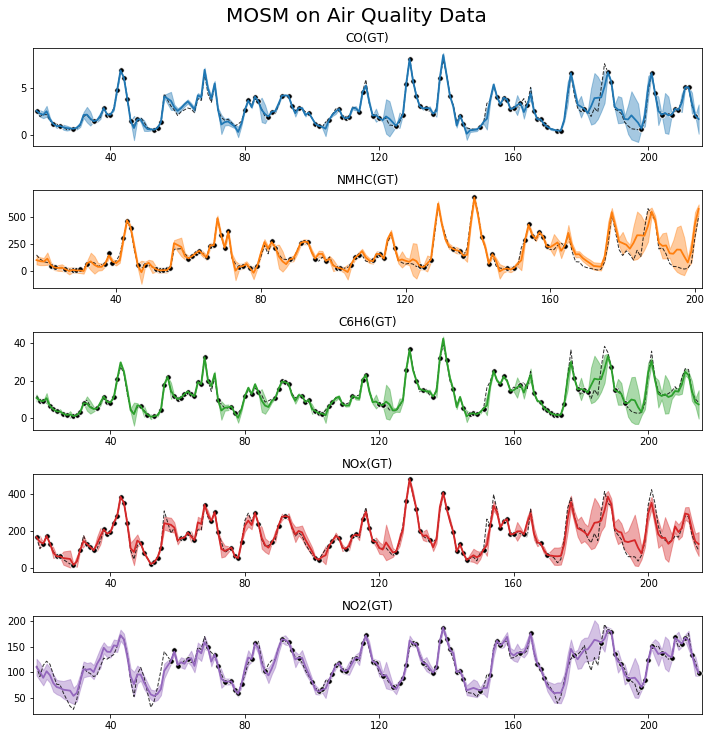

In [9]:
model_mosm = mogptk.MOSM(dataset, Q=4)
model_mosm.init_parameters('BNSE')

model_mosm.train(method='L-BFGS-B', maxiter=1000, tol=1e-15, verbose=True)

model_mosm.predict(x_pred)
model_mosm.plot_prediction(grid=(5, 1), figsize=(10, 10), title='MOSM on Air Quality Data', names=cols);

## 3-Cross Spectral Mixture (CSM)

Then we use the cross spectral mixture kernel (Ulrich et al, 2015)

Starting optimization
 >Model: CSM
 >Channels: 5                    
 >Components: 4
 >Training points: 398
 >Parameters: 54
 >Initial NLL: 485.904
Optimization finished in 2.49 minutes
 >Final NLL: 148.807 



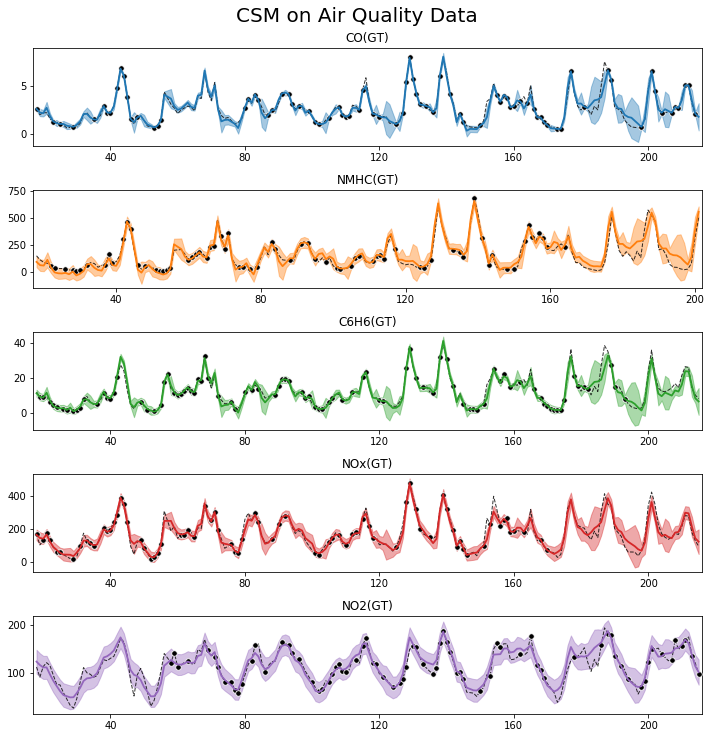

In [10]:
model_csm = mogptk.CSM(dataset, Q=4)
model_csm.init_parameters()

model_csm.train(method='L-BFGS-B', maxiter=1000, tol=1e-15, verbose=True)

model_csm.predict(x_pred)
model_csm.plot_prediction(grid=(5, 1), figsize=(10, 10), title='CSM on Air Quality Data', names=cols);

## 4-Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

Lastly we fit the Spectral mixture- linear model of corregionalization (Wilson, 2014)

Starting optimization
 >Model: SM-LMC
 >Channels: 5                    
 >Components: 4
 >Training points: 398
 >Parameters: 34
 >Initial NLL: 481.779
Optimization finished in 1.78 minutes
 >Final NLL: 146.588 



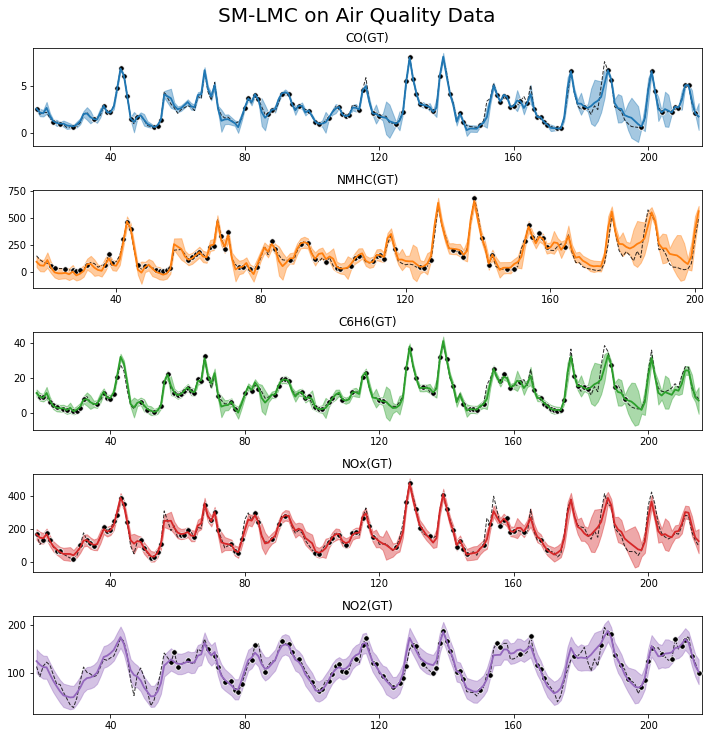

In [11]:
model_smlmc = mogptk.SM_LMC(dataset, Q=4)
model_smlmc.init_parameters()

model_smlmc.train(method='L-BFGS-B', maxiter=1000, tol=1e-15, verbose=True)

model_smlmc.predict(x_pred)
model_smlmc.plot_prediction(grid=(5, 1), figsize=(10, 10), title='SM-LMC on Air Quality Data', names=cols);

## 5-Convolutional Gaussian (CONV)

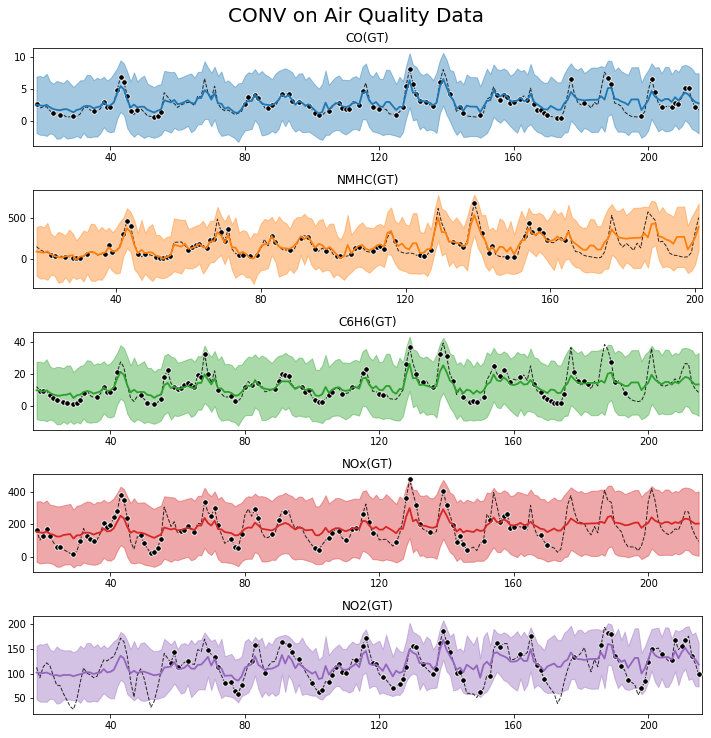

In [12]:
model_conv = mogptk.CONV(dataset, Q=4)
# model_conv.init_parameters()

# model_conv.train(method='L-BFGS-B', maxiter=1000, tol=1e-15, verbose=True)

model_conv.predict(x_pred)
model_conv.plot_prediction(grid=(5, 1), figsize=(10, 10), title='CONV on Air Quality Data', names=cols);

# Compare errors

We will take the mean MAE, nMAE, RMSE, nRMSE for all the channels and compare all the models.

In [13]:
errors = mogptk.test_errors(model_smlmc, model_conv, model_csm, model_mosm,
                           x_test=x_test, y_test=y_test)

In [14]:
pd.DataFrame(np.c_[igp_errors.mean(0),
                   np.array(errors[0]).mean(0),
                   np.array(errors[1]).mean(0),
                   np.array(errors[2]).mean(0),
                   np.array(errors[3]).mean(0),
                  ].T,
             columns=['mean MAE', 'mean nMAE', 'mean RMSE', 'mean nRMSE'],
             index=['IGP', 'SM-LMC', 'CONV', 'CSM', 'MOSM'])

,mean MAE,mean nMAE,mean RMSE,mean nRMSE
IGP,38.535309,0.138682,49.456998,0.177999
SM-LMC,15.692317,0.056732,20.460142,0.076611
CONV,31.084117,0.121814,40.265366,0.160299
CSM,15.929592,0.058321,20.953884,0.079191
MOSM,16.301795,0.060086,22.594546,0.084475
